In [115]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
from sklearn.datasets import make_classification
import pandas as pd
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from IPython import display
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
from collections import defaultdict

import sklearn.datasets

torch.manual_seed(1)
np.random.seed(7)
sns.set(style="white", palette="muted", color_codes=True, context="talk")

%matplotlib inline
print(torch.__version__) 

1.9.1.post3


In [116]:
import time

# Deuterium Stuff & Interval Analysis

In [117]:
%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [118]:
from deuterium import to_vec, random_symbols, get_gradients
from deuterium.autograd import relu, tanh
from sympy import sympify
from scipy.optimize import shgo
import symengine as se
import symengine.lib.symengine_wrapper as sew

In [384]:
def int_analysis(e):
    if isinstance(e, sew.RealDouble):
        return (float(e), float(e))
    elif isinstance(e, sew.FunctionSymbol):
        if e.get_name() == 'tanh':
            arg = e.args[0]
            lower, upper = int_analysis(arg)
            return (np.tanh(lower), np.tanh(upper))
        else:
            raise RuntimeError('unknown function:', e.get_name())
    elif isinstance(e, sew.Integer):
        return (float(e), float(e))
    elif isinstance(e, float):
        return (e, e)
    elif isinstance(e, sew.Symbol):
        return (-1, 1)
    elif isinstance(e, sew.Piecewise):
        print(len(e.args))
        for a in e.args:
            print(a)
        output_1, cond_1, output_2, cond_2 = e.args
        cond_1_lower, cond_1_upper = int_analysis(cond_1)
        print(cond_1_lower, cond_1_upper)
        1/0
    elif isinstance(e, sew.Mul):
        results = [int_analysis(a) for a in e.args]
        lowers = [r[0] for r in results]
        uppers = [r[1] for r in results]
        
        out_lower = lowers[0]
        out_upper = uppers[0]

        for i in range(1, len(e.args)):
            options = [out_lower*lowers[i],
                       out_lower*uppers[i],
                       out_upper*lowers[i],
                       out_upper*uppers[i]]
            out_lower = np.min(options)
            out_upper = np.max(options)

        return out_lower, out_upper
    elif isinstance(e, sew.Pow):
        a, b = e.args
        a_lower, a_upper = int_analysis(a)
        b_lower, b_upper = int_analysis(b)
        assert b_lower == b_upper
        
        if b_lower == 0.5:
            if a_lower < 0:
                print(f'warning: sqrt of negative: [{a_lower}, {a_upper}]')
                return (0, np.sqrt(a_upper))
            else:
                return (max(0, min(np.sqrt(a_lower), np.sqrt(a_upper))),
                        max(np.sqrt(a_lower), np.sqrt(a_upper)))
        elif b_lower == 1.0:
            return (a_lower, a_upper)
        elif b_lower == 2.0:
            return (0, max(a_lower*a_lower, a_upper*a_upper))
        elif b_lower == -2.0:
            raise RuntimeError('this case is broken')
            options = [a_lower * a_lower,
                       a_lower * a_upper,
                       a_upper * a_upper]
            print(e)
            print(options)
            out_lower = np.min(options)
            out_upper = np.max(options)
            return (1/out_lower, 1/out_upper)
        elif b_lower == -1.0:
            raise RuntimeError('unhandled case! power: -1 ()', b_lower, 'target:', a_lower, a_upper)
            if a_lower < 0 and a_upper < 0:
                return (1/a_upper, 1/a_lower)
            else:
                raise RuntimeError('unhandled case! power: -1 ()', b_lower, 'target:', a_lower, a_upper)
        else:
            raise RuntimeError('unhandled case! power:', b_lower, 'target:', a_lower, a_upper)

    elif isinstance(e, sew.Add):
        results = [int_analysis(a) for a in e.args]
        lowers = [r[0] for r in results]
        uppers = [r[1] for r in results]
        return np.sum(lowers), np.sum(uppers)
    else:
        print('fail:', type(e))

# Dataset and Model Definition

In [480]:
n_classes = 2

X, y = sklearn.datasets.make_classification(n_samples=1000,
                                            n_features=2,
                                            n_informative=2,
                                            n_redundant=0,
                                            n_repeated=0,
                                            class_sep=5,
                                            n_classes=n_classes,
                                            random_state = 4)
X = X / np.max(X, axis=0)
n_features = X.shape[1]

In [481]:
(X_train, X_test, y_train, y_test) = train_test_split(X, y, test_size=0.2, random_state=7)
print('len train:', len(X_train))
print('len test:', len(X_test))

len train: 800
len test: 200


In [482]:
BATCH_SIZE = 64

training_dataset = TensorDataset(torch.from_numpy(X_train).float(), 
                                 torch.from_numpy(y_train).long())
train_loader = DataLoader(training_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

testing_dataset = TensorDataset(torch.from_numpy(X_test).float(), 
                                torch.from_numpy(y_test).long())
test_loader = DataLoader(testing_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

In [483]:
class Classifier(nn.Module):
    def __init__(self, n_features, n_hidden=256):
        super(Classifier, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(n_features, n_hidden),
            nn.ReLU(),
            nn.Linear(n_hidden, n_hidden),
            nn.ReLU(),
            nn.Linear(n_hidden, n_hidden),
            nn.ReLU(),
            nn.Linear(n_hidden, n_hidden),
            nn.ReLU(),
            nn.Linear(n_hidden, n_hidden),
            nn.ReLU(),
            nn.Linear(n_hidden, n_classes),
            nn.LogSoftmax()
        )

    def forward(self, x):
        return self.network(x)

In [511]:
n_hidden = 2
class Classifier(nn.Module):
    def __init__(self, n_features, n_hidden=n_hidden):
        super(Classifier, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(n_features, n_hidden, bias=False),
            nn.Tanh(),
            nn.Linear(n_hidden, n_hidden, bias=False),
            nn.Tanh(),
            nn.Linear(n_hidden, n_hidden, bias=False),
            nn.Tanh(),
            nn.Linear(n_hidden, n_hidden, bias=False),
            nn.Tanh(),
            nn.Linear(n_hidden, n_hidden, bias=False),
            nn.Tanh(),
            nn.Linear(n_hidden, 1, bias=False),
            nn.Tanh(),
            #nn.LogSoftmax()
        )

    def forward(self, x):
        return torch.sigmoid(self.network(x))

In [512]:
def accuracy(model, X, y):
    Xt = torch.from_numpy(X).float()
    yt = torch.from_numpy(y).long()
    outputs = model(Xt)
    y_hat = [1 if o>.5 else 0 for o in outputs]
    accuracy = np.sum(y_hat == y) / len(y)
    return accuracy

# Sensitivity Analysis

In [513]:
def bce_grad_bound(y, y_pred_bound, y_pred_prime_bound):
    inside = torch.sigmoid(torch.tensor(y_pred_bound)) - y
    return inside * y_pred_prime_bound

In [514]:
def get_sens(model, y_val):
    IN=n_features
    INTERMEDIATE=n_hidden
    HIDDEN_LAYERS = 4
    
    x = to_vec(np.array(random_symbols(IN, "x")).reshape((1,IN))) 
    ps = list(model.parameters())
    
    # grab the weights from the model
    c = 0
    layers = []
    
    # input layer
    input_layer = to_vec(ps[0].detach().numpy().reshape(IN, INTERMEDIATE))

    # hidden layers
    for i in range(HIDDEN_LAYERS):
        layers.append(to_vec(ps[i+1].detach().numpy().reshape(INTERMEDIATE, INTERMEDIATE)))

    # output layer
    output_layer = to_vec(ps[HIDDEN_LAYERS+1].detach().numpy().reshape(INTERMEDIATE, 1))

    y = to_vec(np.array(y_val))

    network = x@input_layer
    for layer in layers:
        network = network@layer
        network = tanh(network)
    network = network@output_layer
    network = tanh(network)
  
    out = network[0][0]
    out.backward()
    
    all_layers = layers + [input_layer, output_layer]
    grads = [np.array([i.grad for i in w.flatten().tolist()]) for w in all_layers]
    my_grad = to_vec(np.concatenate(grads))
    
    # interval analyses
    y_pred_lower, y_pred_upper = int_analysis(out.data)
    y_pred_prime_lower, y_pred_prime_upper = int_analysis(np.linalg.norm(my_grad, ord=2).data)
    
    options = [bce_grad_bound(y_val, y_pred_lower, y_pred_prime_lower),
               bce_grad_bound(y_val, y_pred_upper, y_pred_prime_lower),
               bce_grad_bound(y_val, y_pred_lower, y_pred_prime_upper),
               bce_grad_bound(y_val, y_pred_upper, y_pred_prime_upper)]
    sens = np.max(options) - np.min(options)
    #print('sens:', sens, 'y:', y_val)
    
    return sens

# Training

In [515]:
def get_eps(epsilon, alpha, delta):
    ed_eps = epsilon + np.log(1/delta)/(alpha - 1)
    print(f'Total epsilon = {ed_eps}, delta = {delta}')
    return ed_eps

In [516]:
def make_plot(info, key, title):
    plt.plot(info[key]);
    plt.title(title)
    plt.show()

In [526]:
def run_experiment(epsilon, epochs, add_noise=False):
    # reset the model
    model = Classifier(n_features=n_features)
    model_criterion = nn.BCELoss() 
    model_optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=0.001)
    
    sensitivities = []
    norms = []
    decays = []

    for epoch in range(epochs):
        for x_batch_train, y_batch_train in train_loader:
            model_optimizer.zero_grad()
            inp = Variable(x_batch_train, requires_grad=True)
            outputs = model.forward(inp)
            loss = model_criterion(outputs, y_batch_train.unsqueeze(1).float())
            loss.backward()
            
            sens = max(get_sens(model, 1.0), get_sens(model, 0))
            sensitivities.append(sens)

            decay = np.mean([np.exp(-k)*sensitivities[-k] for k in range(0, min(len(sensitivities), 20))])
            decay = max(decay, 10)
            decays.append(decay)

#            for p in model.parameters():
#                p.data = p.data / decay
            
            norms.append(next(model.parameters()).data.norm())

            model_optimizer.step()
            

    info = {'sens': sensitivities,
            'norms': norms,
            'decays': decays}
    return model, info

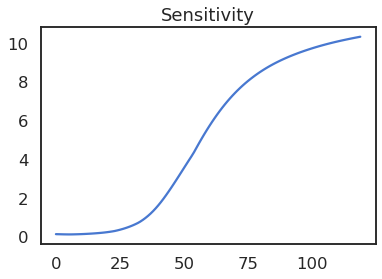

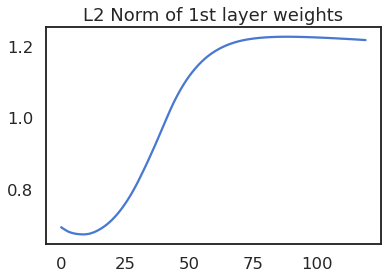

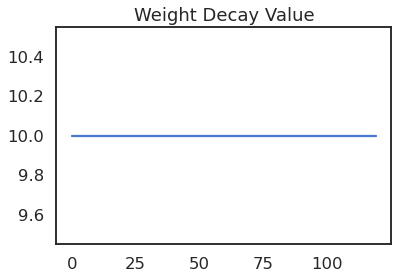

Accuracy: 1.0


In [528]:
model, info = run_experiment(.001, 10, False)

for key, title in [('sens', 'Sensitivity'), 
                   ('norms', 'L2 Norm of 1st layer weights'),
                   ('decays', 'Weight Decay Value')]:
    make_plot(info, key, title)

print('Accuracy:', accuracy(model, X_test, y_test))

In [521]:
info

{'sens': [0.2090320374865204,
  396.8199730731924,
  6.974634410312228e-08,
  5.775804525148928e-11,
  1.3091931966499073e-10,
  6.201570316385728e-10,
  6.125080367366704e-08,
  0.00046665748390895565,
  175.07116135340377,
  0.012651285373862927,
  0.00015523321744731881,
  0.0002639820519066516,
  0.05435506513680142,
  691.3140010381742,
  8.364352260970823e-05,
  3.956374476063702e-10,
  7.365606079232444e-12,
  4.5640036158894e-11,
  4.405317447802118e-09,
  1.947792628293035e-05,
  1.3936893624141615,
  187070.99493041262,
  1.860264828717447e-13,
  5.506489180216498e-13,
  3.4656597332577897e-13,
  2.195410883014586e-13,
  1.4159534169284487e-13,
  9.575041044337219e-14,
  7.346862661892094e-14,
  7.860945916721883e-14,
  1.9349530738488145e-13,
  5.137844218457316e-05,
  2191.428887155433,
  3.4142026617043986e-06,
  1.891764104312941e-13,
  3.919699032156185e-14,
  9.449469210373264e-14,
  4.898772156425313e-13,
  2.7931815077550065e-11,
  6.542766362258783e-08,
  0.008834179

# Old Stuff

In [184]:
model = run_experiment(1, 10, True)
accuracy(model, X_test, y_test)

1.0

In [194]:
def one_experiment(epsilon):
    model = run_experiment(epsilon, 10, True)
    return accuracy(model, X_test, y_test)

In [195]:
def run_experiments():
    epsilons = [0.01, 0.1, 1.0, 10.0, 100.0]
    runs = 10
    alpha = 200
    results = {}
    
    for eps in epsilons:
        ed_eps = get_eps(eps, 200, 1e-5)
        results[ed_eps] = [one_experiment(eps) for _ in range(runs)]
    
    return results

In [196]:
all_results = run_experiments()

Total epsilon = 0.06785389680889561, delta = 1e-05
Total epsilon = 0.1578538968088956, delta = 1e-05
Total epsilon = 1.0578538968088955, delta = 1e-05
Total epsilon = 10.057853896808895, delta = 1e-05
Total epsilon = 100.0578538968089, delta = 1e-05


In [197]:
setting = 'ours'

In [199]:
print(f'{setting}_epsilons = {list(all_results.keys())}')
print(f'{setting}_means = {[np.mean(vs) for vs in all_results.values()]}')
print(f'{setting}_stds = {[np.std(vs) for vs in all_results.values()]}')

ours_epsilons = [0.06785389680889561, 0.1578538968088956, 1.0578538968088955, 10.057853896808895, 100.0578538968089]
ours_means = [0.665, 0.8099999999999999, 0.8720000000000001, 0.9195, 0.9295]
ours_stds = [0.1267675037223657, 0.12599603168354154, 0.055551777649324625, 0.013499999999999995, 0.005220153254455257]
